In [1]:
import gc
import torch
import pandas as pd
import numpy as np
from torch import optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt

import constants
from model.center_net import MyUNet,criterion
from car_dataset import CarDataset

In [2]:
constants.PATH

'../basement-scientists/pku-auto-drive/'

In [3]:
train = pd.read_csv(constants.PATH + '/train.csv')
test = pd.read_csv(constants.PATH + '/sample_submission.csv')
train_images_dir = constants.PATH + 'train_images/{}.jpg'
test_images_dir = constants.PATH + 'test_images/{}.jpg'

df_train, df_dev = train_test_split(train, test_size=0.01, random_state=42)
df_test = test

In [4]:
# Create dataset objects
train_dataset = CarDataset(df_train, train_images_dir, training=True)
dev_dataset = CarDataset(df_dev, train_images_dir, training=False)
test_dataset = CarDataset(df_test, test_images_dir, training=False)

BATCH_SIZE = 1
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [5]:
device = torch.device("cuda")
model = MyUNet(8).to(device)
model.load_state_dict(torch.load("ckpt/model.pth"))

Loaded pretrained weights for efficientnet-b0
The number of classes is 8


<All keys matched successfully>

In [6]:
model.eval()

MyUNet(
  (base_model): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_pr

In [ ]:
# img, mask, regr = dev_dataset[1]

# plt.figure(figsize=(16,16))
# plt.title('Input image')
# plt.imshow(np.rollaxis(img, 0, 3))
# plt.show()

# plt.figure(figsize=(16,16))
# plt.title('Ground truth mask')
# plt.imshow(mask)
# plt.show()

# output = model(torch.tensor(img[None]).to(device))
# logits = output[0,0].data.cpu().numpy()
# print(logits.shape)
# print(np.max(logits))

# plt.figure(figsize=(16,16))
# plt.title('Model predictions')
# plt.imshow(logits)
# plt.show()

# plt.figure(figsize=(16,16))
# plt.title('Model predictions thresholded')
# plt.imshow(logits > 0)
# plt.show()

# logits

In [7]:
import gc
print(device)
torch.cuda.empty_cache()
gc.collect()

cuda


7

output: (1, 8, 60, 192)


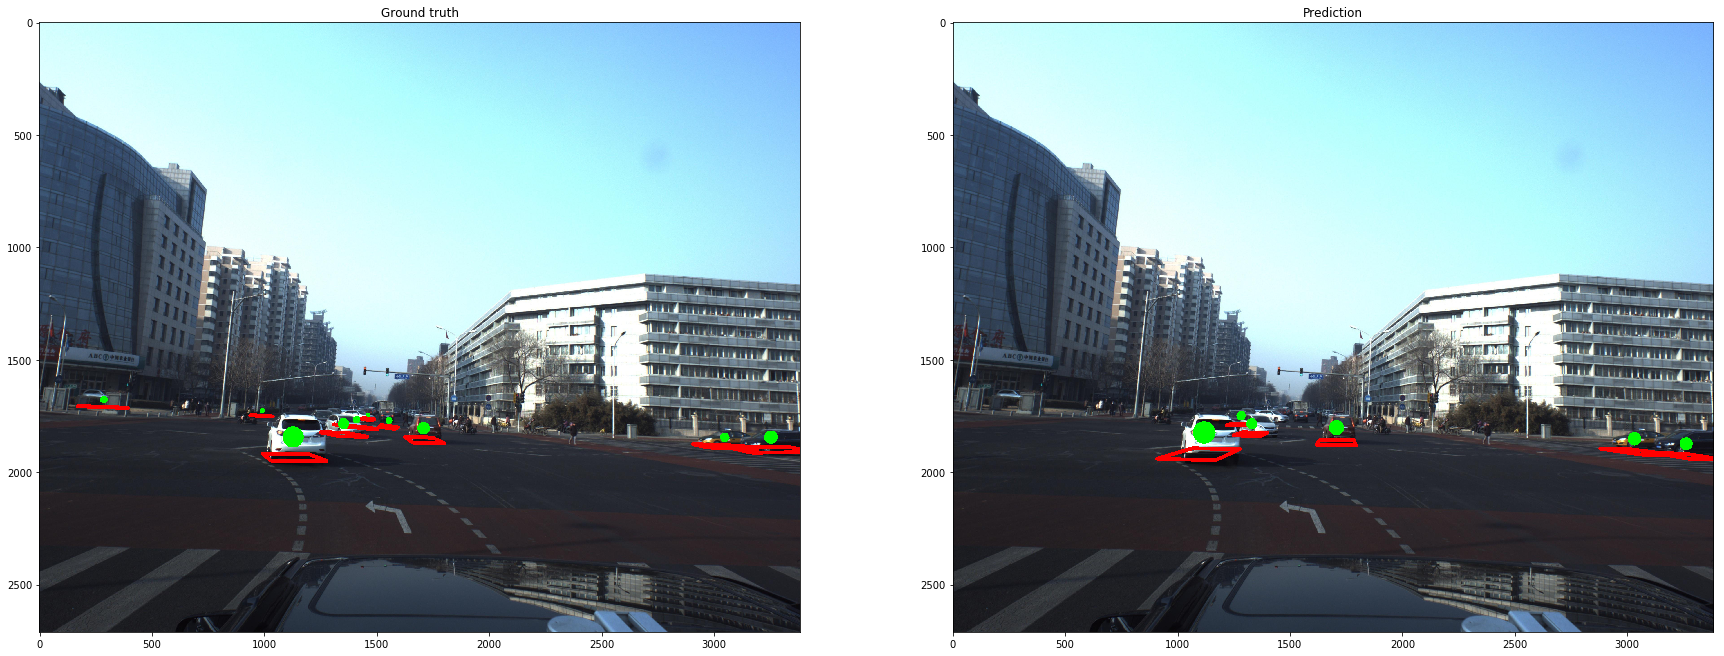

output: (1, 8, 60, 192)


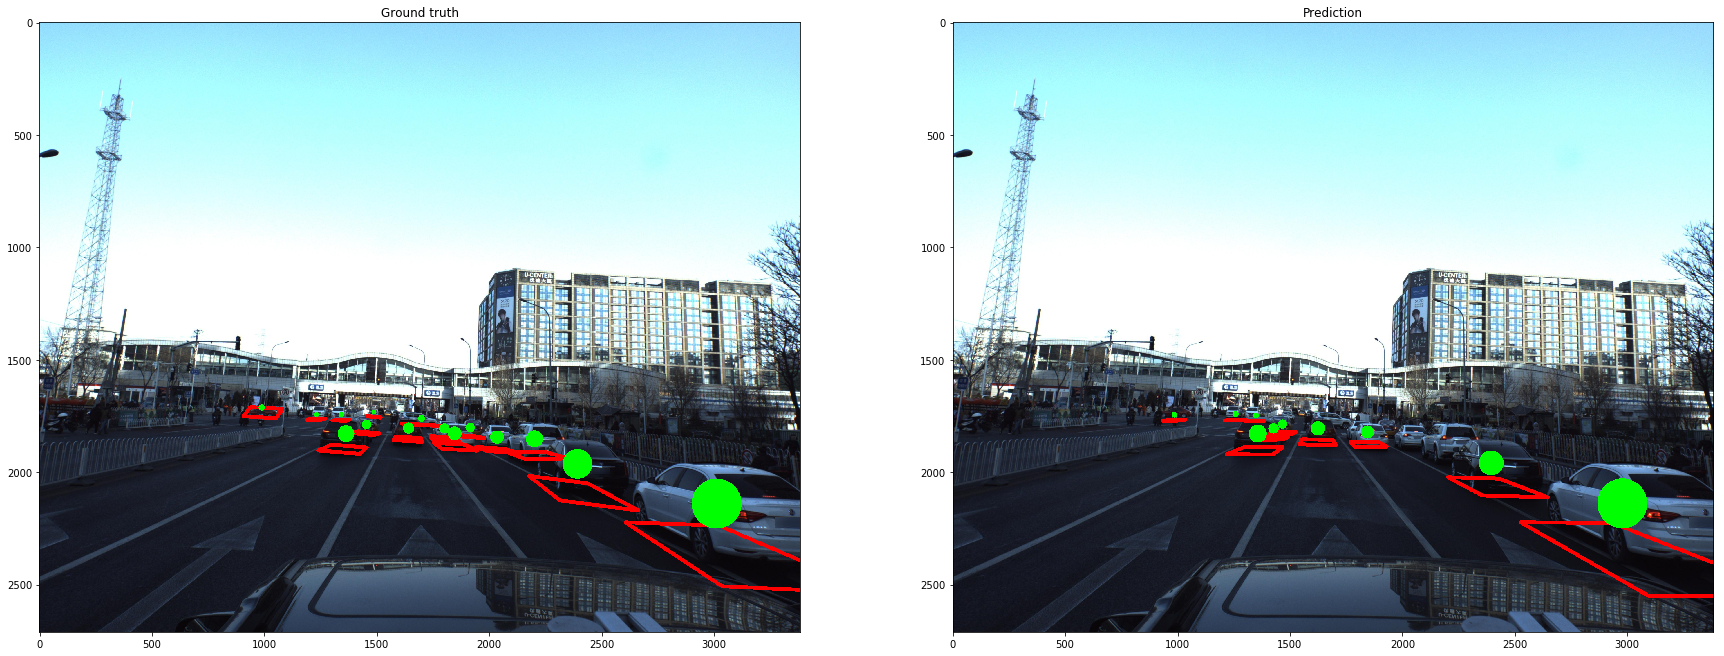

In [8]:
from util import *

gc.collect()

for idx in range(2):
    img, mask, regr = dev_dataset[idx]
    
    output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()
    print("output:", output.shape)
    coords_pred = extract_coords(output[0])
    coords_true = extract_coords(np.concatenate([mask[None], regr], 0))
    
    img = imread(train_images_dir.format(df_dev['ImageId'].iloc[idx]))
    
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(visualize(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(visualize(img, coords_pred))
    
    plt.show()

In [9]:
predictions = []

model.eval()

for img, _, _ in tqdm(test_loader):
    with torch.no_grad():
        output = model(img.to(device))
    output = output.data.cpu().numpy()
    for out in output:
        coords = extract_coords(out)
        s = coords2str(coords)
        predictions.append(s)

100%|██████████████████████████████████████████████████████████████████████████████| 2021/2021 [08:06<00:00,  4.15it/s]


In [10]:
test = pd.read_csv(constants.PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
test.to_csv('predictions.csv', index=False)
# test.head()
test

,ImageId,PredictionString
0,ID_18fb86d04,
1,ID_ce06d4dc1,0.15740262 0.0020593986230210285 3.14098330785...
2,ID_afe07078f,0.14679004 0.00031106283547219617 -3.121370224...
3,ID_37caf75aa,0.1517164 0.1064100874254277 -3.13513331313664...
4,ID_7655363ca,0.15018116 -3.1251841517138317 -3.135787466662...
...,...,...
2016,ID_a36374d4f,0.15087861 0.012155309766158298 -3.14151549165...
2017,ID_998f76276,0.15501812 3.1386541949977937 3.13581122283870...
2018,ID_427dfeea1,0.16260383 -0.004770231748136957 -3.1237394512...
2019,ID_94b297779,0.1592495 -0.011196439862422499 -3.12902833347...
